# **Intro**
In this notebook I set up conditional semi-supervised VAE that attempts to predict the proportions of MNIST numbers that have been superimposed on top of one another.

This is similar to the DIVA, where we use the rotation as labels and instead of having partially labeled numbers, we will have partially labeled number proportions. 
In that setup some labels are ommited to make it semi-supervised, which we will also do.
This will mimic the idea that we have bulk case vs. control examples (we don't know the proportions) and  simulate bulk samples from single-cell profiles, (where we don't have treatment data).
Using both of these sources of data we hope that we can work in OOD stuff.
Also, we use the M1+M2 formulation of semi-supervised as described here: "Semi-supervised Learning with Deep Generative Models", https://arxiv.org/abs/1406.5298

The difference in this model are the following: 


1.   We are learning proportions of numbers in an image, not a specific number.
This means that this is regression, not classification.
2.   We put the constraint directly on mu, not on an external classifier.
This is because we want to be able to augment mu and reconstruct in a logical manner.
For example, we want to be able to simulate the mixture of specific cell types by augmenting mu.
3.   We add in an additional classification loss for classification of treated vs. untreated.
We hope that by learning two separate processes (stack proportions and case/control classification) we will have enough information to compose them and handle out-of-distribution responses.
This did not work when we simply used the treatment as a condition, instead we will need to have a downstream classifier, linked to z, that will predict treatment status.



A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/




# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [31]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [32]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 16
-rw-r--r-- 1 root root  43 Aug 14 04:14 config
-rw------- 1 root root 432 Aug 14 04:14 id_rsa
-rw-r--r-- 1 root root 113 Aug 14 04:14 id_rsa.pub
-rw-r--r-- 1 root root 884 Aug 14 04:06 known_hosts


In [33]:
%%bash
# do your git operations here
git add .
git commit -m "finally got the rotated 1 to be closer to the unotated 1 in the latent space -- however proportions are not accurate. "
git push
git status

[main aa7b6e6] finally got the rotated 1 to be closer to the unotated 1 in the latent space -- however proportions are not accurate.
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite experiments/ssDIVA_stacked_mnist.ipynb (86%)
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


To github.com:nrosed/sc_bulk_ood.git
   6bc210e..aa7b6e6  main -> main


# **Imports**

In [34]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# load methods from other files
from mnist_preprocessing import generate_data as gd

# I disable eager execution ... forgot why
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Populating the interactive namespace from numpy and matplotlib


# **Load / Pre-process data**
Import + reshape the non-rotated MNIST data

In [35]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

print(Y_train)

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 ... 5 6 8]


Import + reshape and rotate MNIST data.
In our single-cell analogy, rotation is a treatment and the number value is a cell-type.

In [36]:
(X_train_r, Y_train_r), (X_test_r, Y_test_r) = mnist.load_data()

# now add in the rotation
def rotate_90(img):
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

# rotate the training data
X_train_r = np.array([rotate_90(xi) for xi in X_train_r])
Y_train_r = Y_train

# rotate the test data
X_test_r = np.array([rotate_90(xi) for xi in X_test_r])
Y_test_r = Y_test

# reshape the data
X_train_r = X_train_r.astype('float32') / 255.
X_test_r = X_test_r.astype('float32') / 255.

n_pixels = np.prod(X_train_r.shape[1:])
X_train_r = X_train_r.reshape((len(X_train_r), n_pixels))
X_test_r = X_test_r.reshape((len(X_test_r), n_pixels))

print(X_train_r.shape)
print(X_test_r.shape)
print(Y_train_r)

(60000, 784)
(10000, 784)
[5 0 4 ... 5 6 8]


Demo the data, to make sure everything works

Proportion of each MNIST number to be superimposed: [ 0  0  0  4  1  2 90  0  3  0]
10 stacked 5's


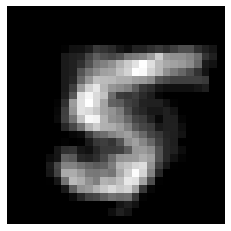

Rotated 10 stacked 5's


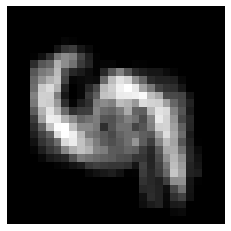

100 stacked 5's


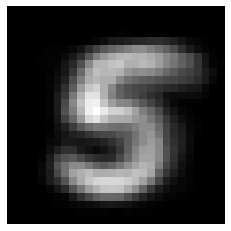

50 random 0's and 50 random 1's


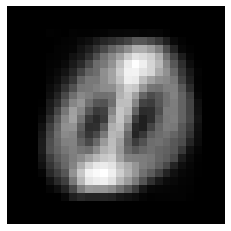

Rotated 50 random 0's and 50 random 1's


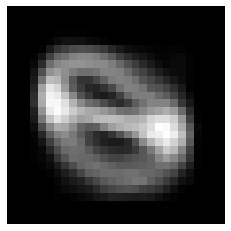

Random Stack


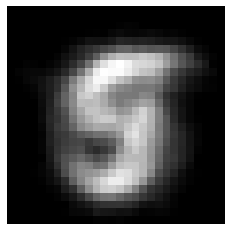

Proportion of each MNIST number: [ 0  1  1  0  1 56  5 17  0 19]
Rotated Random Stack


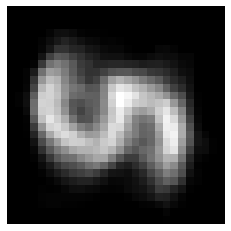

Proportion of each rotated MNIST number: [ 0  1  2 22  0 56 10  1  8  0]


In [37]:
# show how each method works and give some sample output
prop_vec = gd.gen_prop_vec_lognormal()
print(f"Proportion of each MNIST number to be superimposed: {prop_vec}")

# print 10 random 5's
print("10 stacked 5's")
single_num = gd.gen_single_num_sum(10, 5, X_train, Y_train)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 10 random 5's
print("Rotated 10 stacked 5's")
single_num = gd.gen_single_num_sum(10, 5, X_train_r, Y_train_r)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 100 random 5's
print("100 stacked 5's")
single_num = gd.gen_single_num_sum(100, 5, X_train, Y_train)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 50 random 0's and 50 random 1's
print("50 random 0's and 50 random 1's")
zero_five_num = gd.gen_prop_num_sum([50, 50, 0, 0, 0, 0, 0, 0, 0, 0], X_train, Y_train)
plt.imshow(zero_five_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

print("Rotated 50 random 0's and 50 random 1's")
zero_five_num = gd.gen_prop_num_sum([50, 50, 0, 0, 0, 0, 0, 0, 0, 0], X_train_r, Y_train_r)
plt.imshow(zero_five_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

print("Random Stack")
y_stacked, x_stacked = gd.make_stacked_sample(X_train, Y_train)
plt.imshow(x_stacked.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print(f"Proportion of each MNIST number: {y_stacked}")


print("Rotated Random Stack")
y_stacked, x_stacked = gd.make_stacked_sample(X_train_r, Y_train_r)
plt.imshow(x_stacked.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print(f"Proportion of each rotated MNIST number: {y_stacked}")


Now generate all the new images

In [38]:
# in a loop randomly generate images and save the X and Y
num_samples_train = 200000
num_samples_test = 20000

# make / load training data
training_data_path = "./data/stacked_train_lognorm.pkl"
X_stack_train, Y_stack_train =  gd.make_all_stacked_samples(X_train, Y_train, 
                                                         training_data_path, 
                                                         num_samples_train)

# make / load test data
testing_data_path = "./data/stacked_test_lognorm.pkl"
X_stack_test, Y_stack_test =  gd.make_all_stacked_samples(X_test, Y_test, 
                                                         testing_data_path, 
                                                         num_samples_test)


##################################################
#####. Rotated MNIST
##################################################

# make / load training data
training_r_data_path = "./data/stacked_rotated_train_lognorm.pkl"
X_stack_train_r, Y_stack_train_r =  gd.make_all_stacked_samples(X_train_r, 
                                                         Y_train_r, 
                                                         training_r_data_path, 
                                                         num_samples_train)


# make / load test data
testing_r_data_path = "./data/stacked_rotated_test_lognorm.pkl"
X_stack_test_r, Y_stack_test_r =  gd.make_all_stacked_samples(X_test_r, 
                                                         Y_test_r, 
                                                         testing_r_data_path, 
                                                         num_samples_test)

# make / load training data
training_r_data_path = "./data/stacked_rotated_train_lognorm_no1.pkl"
X_stack_train_r_no1, Y_stack_train_r_no1 =  gd.make_all_stacked_samples(X_train_r, 
                                                         Y_train_r, 
                                                         training_r_data_path, 
                                                         num_samples_train,
                                                         num_skip = 1)


# make / load test data
testing_r_data_path = "./data/stacked_rotated_test_lognorm_no1.pkl"
X_stack_test_r_no1, Y_stack_test_r_no1 =  gd.make_all_stacked_samples(X_test_r, 
                                                         Y_test_r, 
                                                         testing_r_data_path, 
                                                         num_samples_test,
                                                         num_skip=1)




# **Model Definition**


## Hyperparameters

In [39]:
batch_size = 500
n_epoch = 5

beta_kl_slack = 10
beta_kl_rot = 10
beta_kl_prop = 10

# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

n_x = X_stack_train.shape[1]
n_y = Y_stack_train.shape[1]
n_label = 2

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")



length of X 784 and length of y 10 and n_label 2


## Encoder

In [40]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))

# concatenate input with the label 
inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_h = Dense(encoder_dim, activation=activ, name="encoder_1")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_z, activation='linear', name = "mu_slack")(encoder_h)
l_sigma_slack = Dense(n_z, activation='linear', name = "sigma_slack")(encoder_h)

mu_prop = Dense(n_z, activation='linear', name = "mu_prop")(encoder_h)
l_sigma_prop = Dense(n_z, activation='linear', name = "sigma_prop")(encoder_h)

mu_rot = Dense(n_label, activation='linear', name = "mu_rot")(encoder_h)
l_sigma_rot = Dense(n_label, activation='linear', name = "sigma_rot")(encoder_h)


## Latent Space

In [41]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_z])
z_prop = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_prop")([mu_prop, l_sigma_prop, n_z])
z_rot = Lambda(sample_z, output_shape = (n_label, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label])

z_concat = concat([z_slack, z_prop, z_rot])

## Decoder + Classifiers

In [42]:
def null_f(args):
    return args

# set up decoder network
# this is a decoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

# this is the proportions we try to estimate
decoder_props = Softmax(name = "mu_prop_pred") # ReLU

# this is the rotation we try to estimate
rot_props = Softmax(name = "mu_rot_pred")

# we use this to get sigma to do sampling later
decoder_sigma = Lambda(null_f, name = "l_sigma_prop_pred")

# link them together
h_p = decoder_hidden(z_concat)
outputs = decoder_out(h_p)

rotation_outputs = rot_props(z_rot)

prop_outputs = decoder_props(mu_prop)
sigma_outputs = decoder_sigma(l_sigma_prop)


d_in = Input(shape=(n_z+n_z+n_label,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)






## Loss

In [43]:

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl_prop = beta_kl_prop * K.sum(K.exp(l_sigma_prop) + K.square(mu_prop) - 1. - l_sigma_prop, axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_prop + kl_rot + kl_slack

def KL_loss(y_true, y_pred):
	return(beta_kl * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

prop_loss_scale = 100
def prop_loss(y_true, y_pred):
	return K.sum((y_true -  y_pred)**2, axis=-1) * prop_loss_scale


def prop_loss_unknown(y_true, y_pred):
  total_loss = 0
  for idx in range(0, 1000):
    y_temp = tf.random.shuffle(y_true)
    total_loss = total_loss + K.sum((y_temp -  y_pred)**2, axis=-1)
  return total_loss / 2.

def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    return recon



## Make the computational graph

In [44]:

known_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs, sigma_outputs])
unknown_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, None]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss_unknown, class_loss]) #, metrics = [KL_loss, recon_loss])


encoder = Model(X, [z_slack, mu_prop, z_rot])

decoder = Model(d_in, d_out)

print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 512)          401920      input_6[0][0]                    
__________________________________________________________________________________________________
sigma_slack (Dense)             (None, 10)           5130        encoder_1[0][0]                  
__________________________________________________________________________________________________
sigma_prop (Dense)              (None, 10)           5130        encoder_1[0][0]                  
____________________________________________________________________________________________

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [45]:
from tqdm import tnrange, tqdm_notebook

y_shuffle = np.zeros((100,10), dtype=np.float32)
y_shuffle[:,1] = 1
for idx in range(0, 40):
  y_shuffle = np.vstack((y_shuffle, np.identity(10, dtype=np.float32)))

def fit_model(X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, epochs):
    assert len(X_known_prop) % len(X_unknown_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        labeled_index = np.arange(len(X_known_prop))
        np.random.shuffle(labeled_index)

        # Repeat the unlabeled data to match length of labeled data
        unlabeled_index = []
        for i in range(len(X_known_prop) // len(X_unknown_prop)):
            l = np.arange(len(X_unknown_prop))
            np.random.shuffle(l)
            unlabeled_index.append(l)
        unlabeled_index = np.concatenate(unlabeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = known_prop_vae.train_on_batch(X_known_prop[index_range], 
                                                      [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range]])
                
                # Unlabeled
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range], 
                                                         [X_unknown_prop[index_range], y_shuffle, label_unknown_prop[index_range]])]


                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

# **Experiments**

Now lets train and evaluate the model.
First we train with only some proportions of rotated 3's..
We will then decrease the proportion of rotated 3's in samples from 0.5 to 0.

In [46]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))


Setup the data so that we remove all the examples with a high proportion of rotated 3's

In [47]:
##################################################
#####. Design the experiment
##################################################

X_full_test = np.concatenate([X_stack_test, X_stack_test_r])
Y_full_test = np.concatenate([Y_stack_test, Y_stack_test_r])

print(X_full_test.shape)

### also create the condition label (regular=0, rotated=1) 

Label_train = np.concatenate([np.zeros(Y_stack_train.shape[0]), np.ones(Y_stack_train_r.shape[0])])
Label_test = np.concatenate([np.zeros(Y_stack_test.shape[0]), np.ones(Y_stack_test_r.shape[0])])
label_train = to_categorical(Label_train)
label_test = to_categorical(Label_test)



# first we take the unrotated and split it into two, 
# for known and unknown proportions
X_train_unrot = X_stack_train
Y_train_unrot = Y_stack_train
label_train_unrot = to_categorical(np.concatenate([np.ones(1), np.zeros(Y_stack_train.shape[0])]))
label_train_unrot = label_train_unrot[1:label_train_unrot.shape[0]]


# split the unrotated into two sets, for known and unknown proportions
sss = StratifiedShuffleSplit(n_splits=2, test_size=100000, random_state=0)
_, index = sss.split(X_train_unrot, label_train_unrot)
X_kp_unrot, label_kp_unrot, y_kp_unrot = X_train_unrot[index[1]], label_train_unrot[index[1]], Y_train_unrot[index[1]]
X_unkp_unrot, label_unkp_unrot, y_unkp_unrot = X_train_unrot[index[0]], label_train_unrot[index[0]], Y_train_unrot[index[0]]


# now take the rotated, with known proportions
# this means we will take rotated_no1 

X_kp_rot = X_stack_train_r_no1
y_kp_rot = Y_stack_train_r_no1
label_kp_rot = to_categorical(np.concatenate([np.zeros(1), np.ones(Y_stack_train_r_no1.shape[0])]))
label_kp_rot = label_kp_rot[1:label_kp_rot.shape[0]]

X_unkp_rot = X_stack_train_r
y_unkp_rot = Y_stack_train_r
label_unkp_rot = to_categorical(np.concatenate([np.zeros(1), np.ones(Y_stack_train_r.shape[0])]))
label_unkp_rot = label_unkp_rot[1:label_unkp_rot.shape[0]]


# for unknown proportions put together the rotated and unrotated
rand_idx = np.random.choice(X_unkp_rot.shape[0], size=X_unkp_unrot.shape[0], replace=False)
X_unkp = np.concatenate((X_unkp_unrot, X_unkp_rot[rand_idx]))
label_unkp = np.concatenate((label_unkp_unrot, label_unkp_rot[rand_idx]))
y_unkp = np.concatenate((y_unkp_unrot, y_unkp_rot[rand_idx]))

# the same for for known proportions put together the rotated and unrotated
X_kp = np.concatenate((X_kp_unrot, X_kp_rot[rand_idx]))
label_kp = np.concatenate((label_kp_unrot, label_kp_rot[rand_idx]))
y_kp = np.concatenate((y_kp_unrot, y_kp_rot[rand_idx]))


# now take a subsample of the full dataset
unkp_size = 50000
kp_size = 50000
unkp_rand_idx = np.random.choice(X_unkp.shape[0], size=unkp_size, replace=False)
kp_rand_idx = np.random.choice(X_kp.shape[0], size=kp_size, replace=False)



(40000, 784)


Now train

In [48]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
history = fit_model(X_unkp[unkp_rand_idx,:],
                    label_unkp[unkp_rand_idx,:],
                    X_kp[kp_rand_idx,:], 
                    y_kp[kp_rand_idx,:],
                    label_kp[kp_rand_idx,:], epochs=10)

print(X_full_test[0].shape) 
print(Y_full_test[0].shape)


z_slack, mu_prop, z_rot = encoder.predict(X_full_test, batch_size=batch_size)
test_error = [mean_abs_error(mu_prop[idx], Y_full_test[idx]) 
                  for idx in range(0, X_full_test.shape[1])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")




  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Elapsed:  279.0377411842346
(784,)
(10,)
mean test_error: 0.173
median test_error: 0.177
max test_error: 0.203


# **Inspect the output**

We will take two examples from our training and see how well it reconstructs.
We first look at the ground truth so we know what we should expect.

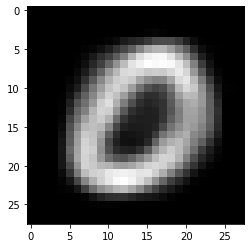

[0.88 0.   0.   0.03 0.01 0.04 0.   0.   0.03 0.01]
[1. 0.]


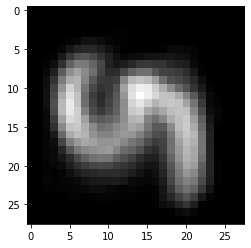

[0.   0.   0.   0.01 0.   0.99 0.   0.   0.   0.  ]
[0. 1.]


In [49]:
plot_idx = 3 #20

plt.imshow(X_unkp_unrot[plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(y_unkp_unrot[plot_idx])
print(label_unkp_unrot[plot_idx])

plt.imshow(X_unkp_rot[plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(y_unkp_rot[plot_idx])
print(label_unkp_rot[plot_idx])


Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

In [50]:
plot_idx = 0

z_slack, mu_prop, z_rot = encoder.predict(X_stack_train, batch_size=batch_size)
encoded_X0 = mu_prop[plot_idx]
rotated_vec = z_rot[plot_idx]
print(f"1-hot encoded condition vector: {Y_stack_train[plot_idx]}\n")

print(f"output from encoder: {encoded_X0}")

encoded_X0[encoded_X0<0] = 0
print(f"output from encoder (ReLU applied): {encoded_X0}")

print(f"rotation: {label_train[plot_idx]}")
print(f"rotation (noReLU applied): {rotated_vec}")
rotated_vec[rotated_vec<0] = 0
print(f"rotation (ReLU applied): {rotated_vec}")

z_slack, mu_prop, z_rot = encoder.predict(X_stack_train_r, batch_size=batch_size)
encoded_X0 = mu_prop[plot_idx]
rotated_vec = z_rot[plot_idx]

print(f"1-hot encoded condition vector: {Y_stack_train_r[plot_idx]}")
print(f"output from encoder (no ReLU applied): {encoded_X0}")
encoded_X0[encoded_X0<0] = 0
print(f"output from encoder (ReLU applied): {encoded_X0}")

print(f"rotation: {label_train[200000+plot_idx]}")
print(f"output from encoder (noReLU applied): {rotated_vec}")
rotated_vec[rotated_vec<0] = 0
print(f"output from encoder (ReLU applied): {rotated_vec}")


1-hot encoded condition vector: [0.   0.   0.   0.89 0.   0.07 0.   0.04 0.   0.  ]

output from encoder: [-0.08735047  0.4361803  -0.05962959  0.3083815  -0.10897834 -0.07373
 -0.08251474 -0.1133309  -0.07806503 -0.10563524]
output from encoder (ReLU applied): [0.        0.4361803 0.        0.3083815 0.        0.        0.
 0.        0.        0.       ]
rotation: [1. 0.]
rotation (noReLU applied): [-1.0156748 -0.9675195]
rotation (ReLU applied): [0. 0.]
1-hot encoded condition vector: [0.02 0.03 0.04 0.9  0.   0.   0.   0.   0.   0.01]
output from encoder (no ReLU applied): [-0.10115926  0.2200073  -0.08004992  0.37473747 -0.06931029 -0.07504562
 -0.09650546 -0.11996317 -0.07304414 -0.08665425]
output from encoder (ReLU applied): [0.         0.2200073  0.         0.37473747 0.         0.
 0.         0.         0.         0.        ]
rotation: [0. 1.]
output from encoder (noReLU applied): [ 0.10247082 -1.6927459 ]
output from encoder (ReLU applied): [0.10247082 0.        ]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.379s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.048427
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.583618
[t-SNE] KL divergence after 300 iterations: 1.659229
t-SNE done! Time elapsed: 11.21129584312439 seconds
(5000, 2)
(5000, 2)


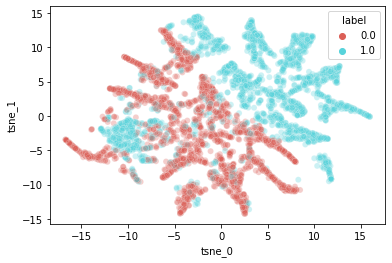

In [51]:
# plot proportions
z_slack, mu_prop, z_rot = encoder.predict(X_full_test, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_full_test.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = Label_test[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)




(5000, 2)
(5000, 2)


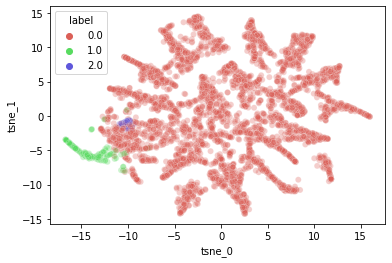

In [52]:

# make a special index for those that are 1
one_unrot_idx = np.concatenate((Y_full_test[0:20000,1] > 0.5, np.zeros(20000, dtype=bool)))
one_rot_idx = np.concatenate((np.zeros(20000, dtype=bool), Y_full_test[20000:40000,1] > 0.9))

one_color = np.zeros(encodings.shape[0])
one_color[one_unrot_idx] = 1
one_color[one_rot_idx] = 2


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = one_color[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 3),
    legend="full",
    alpha=0.3
)




[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.107879
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.384781
[t-SNE] KL divergence after 300 iterations: 1.351857
t-SNE done! Time elapsed: 9.597250699996948 seconds
(5000, 2)
(5000, 2)


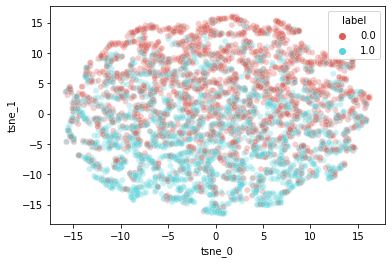

In [53]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_full_test.shape[0], n_label)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = Label_test[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.925567
[t-SNE] KL divergence after 50 iterations with early exaggeration: 85.109879
[t-SNE] KL divergence after 300 iterations: 3.141468
t-SNE done! Time elapsed: 11.599268913269043 seconds
(5000, 2)
(5000, 2)


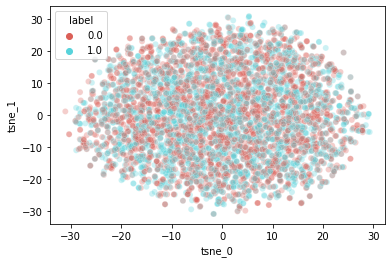

In [54]:
# plot remaining variance
z_test = z_slack
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_full_test.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = Label_test[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)



In [55]:
print(X_full_test[0].shape) 
print(Y_full_test[0].shape)

def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

z_slack, mu_prop, z_rot = encoder.predict(X_full_test, batch_size=batch_size)

test_error = [mean_abs_error(mu_prop[idx], Y_full_test[idx]) 
                  for idx in range(0, X_full_test.shape[0])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")



(784,)
(10,)
mean test_error: 0.163
median test_error: 0.167
max test_error: 0.228


661
rotated 3


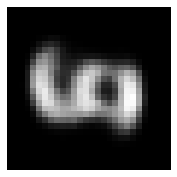

In [56]:

def method_sample_z(args):
    mu, l_sigma = args
    eps = np.random.normal(size=(batch_size, n_z), loc=0., scale=1.)
    return mu + np.exp(l_sigma / 2) * eps

def sample_digit(digit, Y_test, digit_scale, rotate):
  digit_idx = np.where(Y_test == digit)

  label_vec = np.array([1., -1.]).reshape((1, 2))
  if rotate:
    label_vec = np.array([-1., 1.]).reshape((1, 2))

  pred_input = X_full_test[digit_idx[0]]
  rand_idx = np.random.choice(pred_input.shape[0], size=batch_size, replace=False)
  pred_input = pred_input[rand_idx]

  test_X, test_mu, test_label, test_lsigma = known_prop_vae.predict(pred_input, batch_size=batch_size)

  encoded_X0 = np.ones(10)*0.0001
  encoded_X0[digit] = digit_scale
  rand_lsigma = np.random.random_integers(low = 0, high = 249)
  z_0_digit = method_sample_z([encoded_X0, test_lsigma])
  z_0_digit = z_0_digit[rand_lsigma].reshape((1,10))
  return(z_0_digit)

digit_img = 3

keep_rot_idx = Y_full_test[:,digit_img] > 0.9
print(sum(keep_rot_idx))
X_example = X_full_test[keep_rot_idx,]
z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

z_0_digit = sample_digit(digit_img, Y_test, 10, rotate=True)
plt.figure(figsize=(3, 3))

# it is rotated
rotate_1hot = np.array([-10., 10.])

# slack, prop, rot
slack_sample = z_slack[0]
slack_sample = [0,0,0,0,0,0,0,0,0,0]
pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

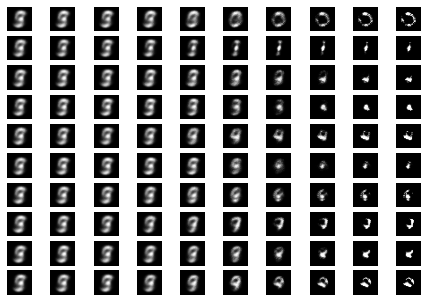

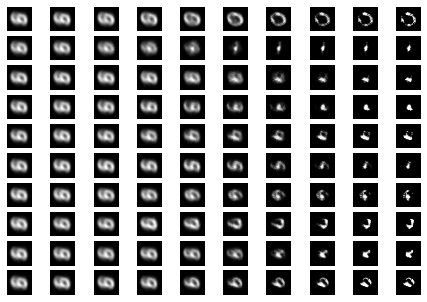

In [57]:
img_it = 0
sides = 10
slack_sample = [0,0,0,0,0,0,0,0,0,0]
rotate_scale = 10


rotate_1hot = np.array([rotate_scale, 0.])
rotate_val = False
for i in range(0, sides):
    for j in range(0, sides):
        z_0_digit = sample_digit(i, Y_test, 2**j, rotate=rotate_val)

        digit_img = i

        keep_rot_idx = Y_full_test[:,digit_img] > 0.9
        X_example = X_full_test[keep_rot_idx,]
        z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

        # slack, prop, rot
        slack_sample = z_slack[0]
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

        decoded = decoder.predict(pred_input)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()


rotate_1hot = np.array([0., rotate_scale])
rotate_val = True
img_it = 0
sides = 10
for i in range(0, sides):
    for j in range(0, sides):
        z_0_digit = sample_digit(i, Y_test, 2**j, rotate=rotate_val)
        digit_img = i

        keep_rot_idx = Y_full_test[:,digit_img] > 0.9
        X_example = X_full_test[keep_rot_idx,]
        z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

        # slack, prop, rot
        slack_sample = z_slack[0]
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

        decoded = decoder.predict(pred_input)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

In [58]:
# predict rotated numbers

# normalizing the data to make the neural network easier to learn
x_train_r = normalize(X_train_r, axis=1)
x_test_r = normalize(X_test_r, axis=1)

#choosing the sequential model
classification_model = Sequential()

#defining the architecture of the model
X_class = Input(shape=(n_x,))
classification_model.add(X_class)
classification_model.add(Dense(512, activation='relu'))
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
classification_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#training the model
classification_model.fit(x_train_r,Y_train_r,epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 157us/sample - loss: 0.2534 - accuracy: 0.9267
Epoch 2/5
60000/60000 [==============================] - 9s 149us/sample - loss: 0.0966 - accuracy: 0.9703
Epoch 3/5
60000/60000 [==============================] - 9s 148us/sample - loss: 0.0620 - accuracy: 0.9803
Epoch 4/5
60000/60000 [==============================] - 9s 151us/sample - loss: 0.0448 - accuracy: 0.9858
Epoch 5/5
60000/60000 [==============================] - 9s 150us/sample - loss: 0.0324 - accuracy: 0.9892


In [59]:

num_correct = 0
num_digits = 10
num_rep = 100
rotate_1hot = np.array([0., 10])
rotate_val = True
slack_sample = method_sample_z([0,1])[0]
acc = []
for digit_idx in range(0, num_digits):
  num_correct = 0
  for idx_rep in range(0, num_rep):
    z_0_digit = sample_digit(digit_idx, Y_test, 2**5, rotate=rotate_val)
    digit_img = digit_idx

    keep_rot_idx = Y_full_test[:,digit_img] > 0.9
    X_example = X_full_test[keep_rot_idx,]
    z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

    # slack, prop, rot
    slack_sample = z_slack[10]
    slack_sample = [0,0,0,0,0,0,0,0,0,0]
    pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))


    decoded = decoder.predict(pred_input)
    predictions = classification_model.predict(decoded)
    #print(f"true: {idx} pred: {np.argmax(predictions)}")
    if(digit_idx == np.argmax(predictions)):
      num_correct += 1
  acc = np.append(acc, num_correct)

print(np.mean(acc))
print(acc)

46.5
[100.   0.   0.   0. 100.   0. 100.  65.   0. 100.]


rotated 1


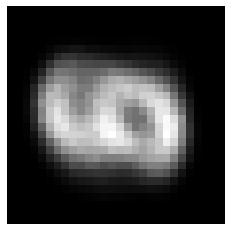

rotated 1


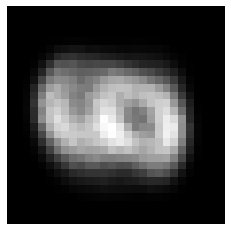

rotated 1


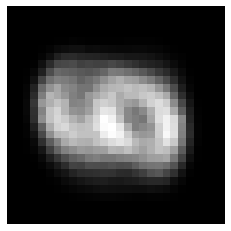

rotated 1


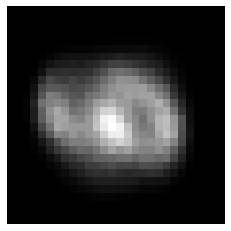

rotated 1


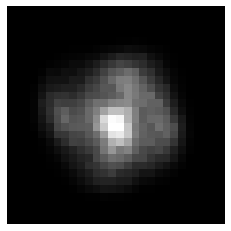

rotated 1


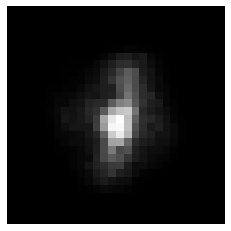

rotated 1


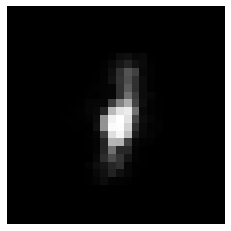

rotated 1


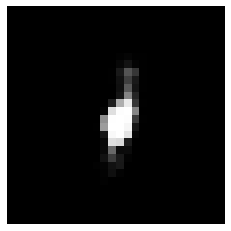

rotated 1


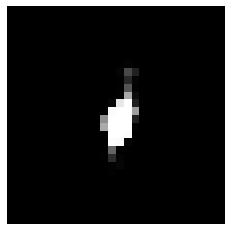

rotated 1


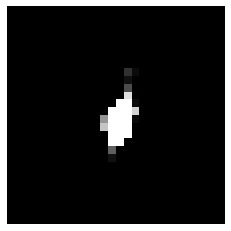

In [60]:
digit_idx=1
for idx_rep in range(0, 10):
  z_0_digit = sample_digit(digit_idx, Y_test, 2**idx_rep, rotate=rotate_val)
  digit_img = digit_idx

  keep_rot_idx = Y_full_test[:,digit_img] > 0.9
  X_example = X_full_test[keep_rot_idx,]
  z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

  # slack, prop, rot
  slack_sample = [0,0,0,0,0,0,0,0,0,0]
  pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

  print(f"rotated {digit_img}")
  plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
  plt.show()

